In [1]:
import pandas as pd
import re
from re import compile, search
from os.path import join

import warnings
warnings.filterwarnings('ignore')

### Import raw data from crawler

In [2]:
file_name = 'sample_full.json'
df_sample = pd.read_json(join('..', 'data', 'crawler', file_name))

### NER extraction

#### Objects with structured description

In [3]:
regexps = {
    'name': compile('име обект: (?P<name>.*?) вид обект'),
    'category': compile('вид обект: (?P<category>.*?) град'),
    'city': compile('град: (?P<city>.*?) адрес'),
    'address': compile('адрес: (?P<address>.*?) описание')
}

def match(prop, text):
    m = regexps[prop].search(text)
    if m is not None:
        return m.group(prop).strip()
    else:
        return None

In [4]:
df_sample['matched_name'] = df_sample['description'].apply(lambda x: match('name', x))
df_sample['matched_category'] = df_sample['description'].apply(lambda x: match('category', x))
df_sample['matched_city'] = df_sample['description'].apply(lambda x: match('city', x))
df_sample['matched_address'] = df_sample['description'].apply(lambda x: match('address', x))

In [5]:
df_sample['matched_name'].count()

2070

In [6]:
df_sample['matched_city'].count()

2077

In [7]:
df_sample['matched_address'].count()

2064

In [8]:
df_sample['matched_category'].count()

2077

#### Categories based on matched_category

In [9]:
categories = list(filter(lambda x: x is not None, df_sample['matched_category'].unique()))

Parsing to get set of unique categories

In [10]:
def parse_category(category):
    splitted = re.split(r'[-\\\/,\.:]', category)
    return [w.strip().lower() for w in splitted]

def flatten(l):
    return sum(l, [])

all_cats = flatten([ parse_category(category) for category in categories])
unique_cats = set([cat for cat in all_cats if len(cat) > 2])
cat_group = "|".join(unique_cats)

#### Objects with non structured description

In [11]:
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.tag import pos_tag, RegexpTagger
from nltk.chunk.regexp import RegexpChunkParser, RegexpChunkRule
from nltk.tree import Tree

Custom pos-tags

In [12]:
regexp_tagger = RegexpTagger([
    ("^{}$".format(cat_group), 'PLACE_MARKER'),
    (r'^[,]$', 'DT'),
    (r'^в$', 'BEG'),
    (r'^[A-Za-z0-9 &]+$', 'LATIN_WORD'),
    (r'^[а-яА-Я0-9 &]+$', 'CYRILLIC_WORD')
])

Tokenize with word_tokenize and TweetTokenizer

In [13]:
tweet_token = TweetTokenizer().tokenize

def tokenize(title, tokenizer):
    words = tokenizer(title)
    tokens = regexp_tagger.tag(words)
    return [token for token in tokens if token[1] is not None]

Chunkparser to extract name.

In [14]:
chuncker = RegexpChunkParser([
        RegexpChunkRule.fromstring(r'{<BEG> (<LATIN_WORD>|<CYRILLIC_WORD>)+ <PLACE_MARKER>+ (<LATIN_WORD>|<CYRILLIC_WORD>)* (?=<DT>|<BEG>)*}'),
        RegexpChunkRule.fromstring(r'{(<PLACE_MARKER>+ (<LATIN_WORD>|<CYRILLIC_WORD>)+)+ <PLACE_MARKER>* (?=<DT>|<BEG>)*}'),
        RegexpChunkRule.fromstring(r'{<PLACE_MARKER>+ (<LATIN_WORD>|<CYRILLIC_WORD>)+ (?=<DT>|<BEG>)*}'),
    ],
    chunk_label='Name'
)


def get_words(tree):
    return [word for word in tree.leaves()]

def find_name(title, tokenizer, visual=False):
    if title is "":
        return None
    
    title = title.lower()
    tokens = tokenize(title, tokenizer)
    tree = chuncker.parse(tokens)
    chunk_tree = [t.leaves() for t in tree if type(t) is Tree]
    flattened = sum(chunk_tree, [])
    filtered = [(w.strip(), m) for w, m in flattened if w != "в"]
    if visual:
        return tree
    return filtered

#### Examples

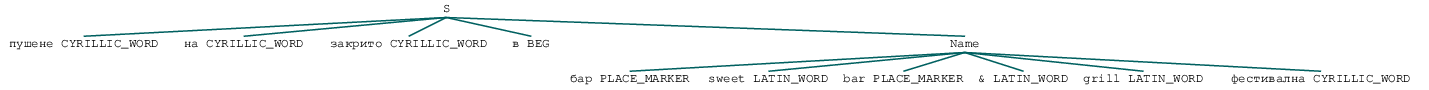

In [15]:
tree = find_name('Пушене на закрито в бар Sweet bar&grill Фестивална', tweet_token, visual=True)

tree

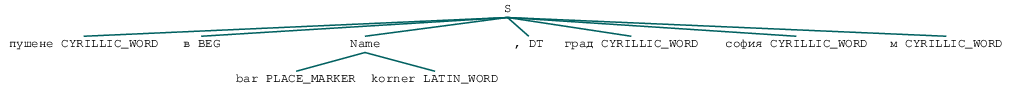

In [16]:
tree = find_name('Пушене в Bar "Korner", град София (м)', tweet_token, visual=True)

tree

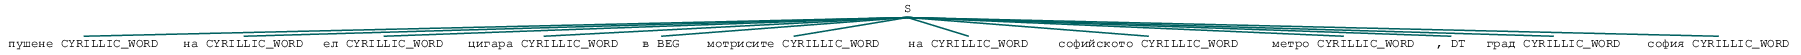

In [17]:
tree = find_name('Пушене на ел.цигара в мотрисите на Софийското метро, град София', tweet_token, visual=True)

tree

#### Apply functions to extract name for all objects

In [18]:
df_sample['matched_title'] = df_sample['title'].apply(lambda x: find_name(x, tweet_token))

In [19]:
df_sample['matched_title_2'] = df_sample['title'].apply(lambda x: find_name(x, word_tokenize))

In [20]:
def concat_title(tuples):
    if tuples == [] or tuples is None:
        return None
    name = []
    for word, marker in tuples:
        name.append(word)
        
    return ' '.join(name)

In [21]:
df_sample['matched_title_str'] = df_sample['matched_title'].apply(concat_title)

In [22]:
df_sample['matched_title_2_str'] = df_sample['matched_title_2'].apply(concat_title)

### Final DF and Export

In [23]:
df_sample

,categories,date,description,files,id,location,title,matched_name,matched_category,matched_city,matched_address,matched_title,matched_title_2,matched_title_str,matched_title_2_str
0,[заведение за хранене и развлечение],10:34 Jan 10 2019,"В момента се намирам в заведение ""Бакарди"" в г...",[],10533,"град Бургас, ул. Александровска № 51","Пушене в заведение ""Бакарди"", град Бургас",None,None,None,None,"[(заведение, PLACE_MARKER), (бакарди, CYRILLIC...","[(заведение, PLACE_MARKER), (бакарди, CYRILLIC...",заведение бакарди,заведение бакарди
1,[заведение за хранене и развлечение],08:31 Jan 10 2019,Не съм сигурен вече за кой пореден път подавам...,[{'url': 'https://bezdim.org/signali/media/upl...,10536,"град София, ж.к Гео Милев, Зала Фестивална","Пушене в заведение, пореден път, град София",None,None,None,None,[],[],None,None
2,[заведение за хранене и развлечение],09:30 Mar 30 2018,"В сладкарница Малинка, пушат навсякъде! * Сигн...",[{'url': 'https://bezdim.org/signali/media/upl...,10244,"град София, кв. Младост, сп. Окръжна болница, ...","Пушене в сладкарница Малинка, град София",None,None,None,None,"[(сладкарница, PLACE_MARKER), (малинка, CYRILL...","[(сладкарница, PLACE_MARKER), (малинка, CYRILL...",сладкарница малинка,сладкарница малинка
3,[заведение за хранене и развлечение],02:13 Mar 31 2018,В Глори бар и грил се пуши дори през деня. * С...,[{'url': 'https://bezdim.org/signali/media/upl...,10249,"град София, ул. Пирински проход 24 А","Неспазване на забраната за тютюнопушене, град ...",None,None,None,None,[],[],None,None
4,[заведение за хранене и развлечение],11:00 Jul 27 2018,име обект: Камино вид обект: пиано бар град: С...,[{'url': 'https://bezdim.org/signali/media/upl...,10362,"град София , ул. Неофит Рилски № 70","Пушене в пиано бар ""Камино"", град София (м)",Камино,пиано бар,София,ул. Неофит Рилски № 70,"[(пиано, PLACE_MARKER), (бар, PLACE_MARKER), (...","[(пиано, PLACE_MARKER), (бар, PLACE_MARKER), (...",пиано бар камино,пиано бар камино
5,[заведение за хранене и развлечение],04:57 Apr 1 2018,"Здравейте, Моля за Вашето съдействие за взиман...",[],10252,"град Перник, ул. „Отец Паисий“ 8",Тютюнопушене и липса на климатизация в механа ...,None,None,None,None,"[(механа, PLACE_MARKER), (гераци, CYRILLIC_WORD)]","[(механа, PLACE_MARKER), (гераци, CYRILLIC_WORD)]",механа гераци,механа гераци
6,[заведение за хранене и развлечение],00:43 Nov 11 2018,"В ресторант Родопска къща в Студентски град, С...",[{'url': 'https://bezdim.org/signali/media/upl...,10412,"град София, ул. ""8-ми декември"", блок 21","Пушене в ресторант Родопска къща, град София",None,None,None,None,"[(ресторант, PLACE_MARKER), (родопска, CYRILLI...","[(ресторант, PLACE_MARKER), (родопска, CYRILLI...",ресторант родопска къща,ресторант родопска къща
7,[заведение за хранене и развлечение],11:00 Feb 23 2018,име обект: Рико-33 ЕООД вид обект: Кафе-аперит...,[{'url': 'https://bezdim.org/signali/media/upl...,10173,"село Ракита, област Плевен, ул. ”Георги Димитр...","Пушене в кафе-аперитив/магазин ""Рико-33 ЕООД"",...",Рико-33 ЕООД,Кафе-аперитив/магазин,"село Ракита,област Плевен","област Плевен,с.Ракита,ул.”Георги Димитров” № 7","[(кафе-аперитив, PLACE_MARKER), (магазин, PLAC...","[(кафе-аперитив/магазин, PLACE_MARKER), (еоод,...",кафе-аперитив магазин рико 33 еоод,кафе-аперитив/магазин еоод
8,[заведение за хранене и развлечение],09:37 Oct 10 2018,"Днес от 19:00 до 20:30 в заведението ""Дъ ривър...",[{'url': 'https://bezdim.org/signali/media/upl...,10395,"град Русе, ул. Чавдар Войвода 33 /пресечна с б...",нарушение на действащата забрана за тютюнопуше...,None,None,None,None,[],[],None,None
9,[заведение за хранене и развлечение],08:33 Nov 26 2017,В събота 18.11.2017 след 02:00ч в клуба се пуш...,[{'url': 'https://bezdim.org/signali/media/upl...,9936,"град София, ул. ""Георги С. Раковски"" 113","Пушене в Dirty Sofia, град София",None,None,None,None,[],[],None,None


In [38]:
df_sample.to_json(join('..', 'data', 'ner', 'sample_full_names_tokens.json'), orient='split')

In [39]:
pd.read_json(join('..', 'data', 'ner', 'sample_full_names_tokens.json'), orient='split').count()

categories             8875
date                   8875
description            8875
files                  8875
id                     8875
location               8875
title                  8875
matched_name           2070
matched_category       2077
matched_city           2077
matched_address        2064
matched_title          8864
matched_title_2        8864
matched_title_str      6285
matched_title_2_str    6281
dtype: int64